### Workspace

In [74]:
%matplotlib notebook

from modsim import *

In [75]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y

dd_da = interpolate(dd_da, kind='cubic')

In [76]:
condition = Condition(height=90000,
                      thrust_on=200,
                      f_thrust=20,
                      mass=1,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=1,
                      g=9.8,
                      dt=1,
                      t_end=500)

In [97]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0)
    
    drag_coef = -C_d*length*width / 2
    
    steps = (t_end)/dt + 1
    series = linspace(0,t_end, steps)
    
    system = System(init=init,
                    series=series,
                    dt=dt,
                    thrust_on=thrust_on,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    dd_da=dd_da,
                    t1=-1, t2=-1,
                    t_end = t_end)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity = state
    
    if (height < thrust_on):
        f_t=f_thrust
    else:
        f_t=0
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
    
    if(f_t > 0 and system.t1==-1 and a>0):
        system.t1=dt*count
    elif(a < 0 and system.t1 != -1 and system.t2 == -1):
        system.t2 = dt*count
        
    return State(height=height, velocity=velocity)

def run_ode_better(system, slope_func):
    count = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    for i in series:
        if(i < t_end):
            frame.loc[i+dt] = slope_func(frame.loc[i], system, dt, count)
        else:
            system.results = frame
        count += 1
    system.count = count
    
def plot_height(results):
    newfig()
    unpack(results)
    
    plot(height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

    
def plot_velocity(results):
    newfig()
    unpack(results)
    
    plot(velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m)')
    
def height_at_zero(system):
    unpack(system)
    velocity = system.results.velocity[t1:t2]
    time = velocity.idxmin()
    t = interp_inverse(velocity)
    
    #time = t(0)
    y = interpolate(system.results.height)
    height = y(time)
    return height

def run_simulation(t_on):
    system = make_system(condition)
    condition.set(thrust_on = t_on)
    run_ode_better(system, slope)
    #print(system.thrust_on)
    system.final_height = height_at_zero(system)
    
    return system

In [98]:
condition.set(dt=1)
condition.set(t_end = 300)
condition.set(height = 1000)

run1 = run_simulation(1000)

In [99]:
run1.final_height

array(20.760492668951017)

<IPython.core.display.Javascript object>


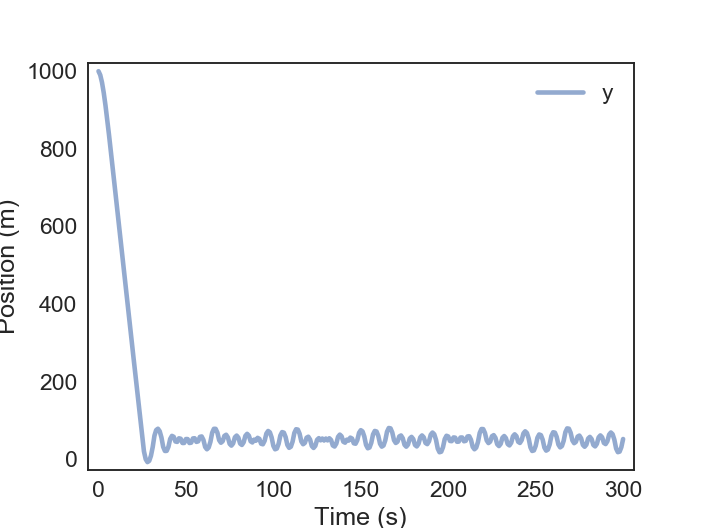

In [100]:
plot_height(run1.results)

<IPython.core.display.Javascript object>


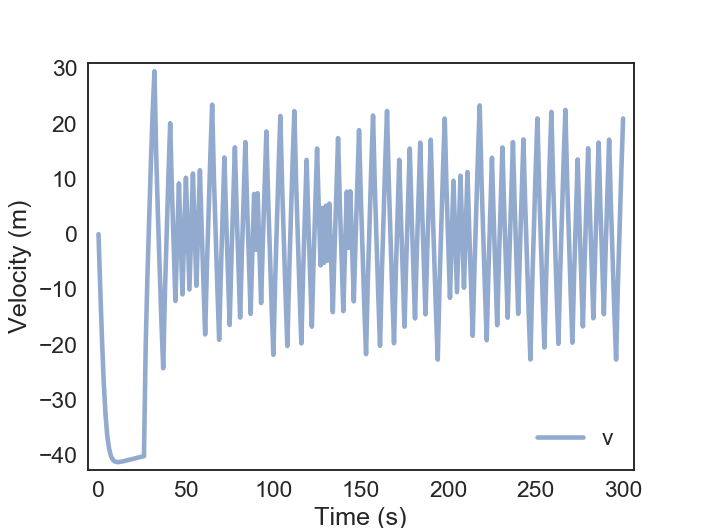

In [101]:
plot_velocity(run1.results)

In [103]:
sweep = SweepSeries()
condition.set(dt=.25)
for thrust in linrange(1, 50, 1):
    system57 = run_simulation(thrust)
    print(system57.thrust_on)
    print(system57.final_height)
    #print(system57.t1)
    #print(system.results.height[system.t_end])
    sweep[thrust] = system57.final_height

8.0
3.416969958320875
1.0
-6.619480750573855
2.0
-6.619480750573855
3.0
-6.619480750573855
4.0
3.416969958320875
5.0
3.416969958320875
6.0
3.416969958320875
7.0
3.416969958320875
8.0
3.416969958320875
9.0
3.416969958320875
10.0
3.416969958320875
11.0
3.416969958320875
12.0
3.416969958320875
13.0
3.416969958320875
14.0
13.458290747402845
15.0
13.458290747402845
16.0
13.458290747402845


KeyError: 'the label [39.0] is not in the [index]'

<IPython.core.display.Javascript object>


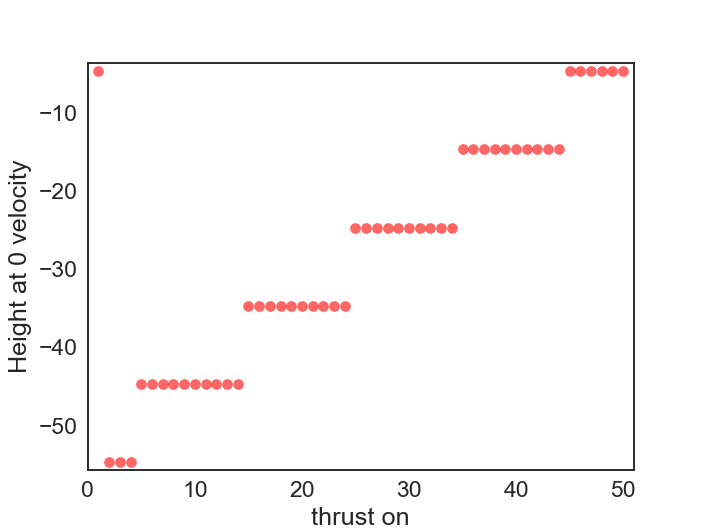

In [95]:
newfig()
plot(sweep, 'ro')
decorate(xlabel='thrust on',
         ylabel='Height at 0 velocity',
         legend=False)

In [72]:
sweep

,value
1,991.053141931469
2,-44.56418579808036
3,-44.56418579808036
4,-44.56418579808036
5,-44.56418579808036
6,-44.56418579808036
7,-44.56418579808036
8,-44.56418579808036
9,-44.56418579808036
10,-44.56418579808036


In [84]:
linrange(1, 50, 1)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.])